In [13]:
import tensorflow as tf

In [14]:
from tensorflow.keras.utils import image_dataset_from_directory
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

## DATA EXPLORATION

### Load data

In [15]:
!pwd

/Users/thomas/code/wroby/foodE/notebooks


In [16]:
PATH = "../raw_data/food-101/food-101-train/images"
PATH_test = "../raw_data/food-101/food-101-test/images"


### Train/test split

In [17]:
train = image_dataset_from_directory(PATH,label_mode="categorical", color_mode="rgb",
                                     labels='inferred',
                                  validation_split=0.2, subset="training",
                                  image_size=(512,512), interpolation="nearest",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)

Found 80800 files belonging to 101 classes.
Using 64640 files for training.


In [18]:
validation = image_dataset_from_directory(PATH,label_mode="categorical", color_mode="rgb",
                                          labels='inferred',
                                  validation_split=0.2, subset="validation",
                                  image_size=(512,512), interpolation="nearest",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)

Found 80800 files belonging to 101 classes.
Using 16160 files for validation.


In [19]:
test = image_dataset_from_directory(PATH_test, label_mode="categorical", color_mode="rgb", 
                                    labels='inferred',
                                  image_size=(512,512), interpolation="nearest",
                                  crop_to_aspect_ratio=True,
                                  seed=42, shuffle=True, batch_size=32)

Found 20200 files belonging to 101 classes.


In [20]:
#label name
class_names = train.class_names
print("Class names:", class_names)

Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macaron

### Visualise datasets


2023-02-02 19:15:09.367414: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


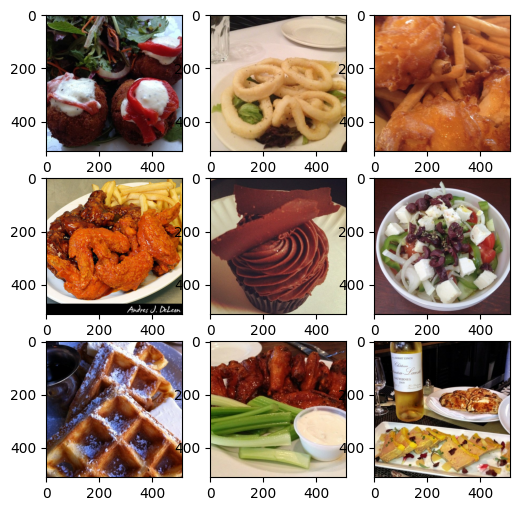

In [21]:
fig, ax = plt.subplots(3, 3, figsize=(6,6))
 
for images, labels in train.take(1):
    for i in range(3):
        ax[0][i].imshow(images[i].numpy().astype("uint8"))
    for i in range(3):
        ax[1][i].imshow(images[i+3].numpy().astype("uint8"))
    for i in range(3):
        ax[2][i].imshow(images[i+6].numpy().astype("uint8"))
plt.show()

## Preprocessing

#### Model to choose
VGG16 - celui du cours, mais il est un peu pété -
MobileNetV2 - solide et légé mais moins accurate -
EfficientnetB2 - celui la est top mais prends bcp de ressources -
InceptionV3 : 88.28% / 96.88% (Top 1/Top 5) - tres souvent utilisé -
ResNet200 : 90.14% (Top 1) - tres souvent utilisé -
WISeR : 90.27% / 98.71% (Top 1/Top 5) - pas vu tres souvent -

In [22]:
## Definir la function preprocess
def preprocessing(images, labels):
    ## Use the preprocess_input for each specific model
    return tf.keras.applications.mobilenet_v2.preprocess_input(tf.image.convert_image_dtype(images, tf.float32)), labels
    ## will scale input pixels between -1 and 1
    
## Appliquer la function sur le dataset
train = train.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
validation = validation.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)

NameError: name 'preprocess' is not defined

In [ ]:
# Cache the preprocessed data in memory and prefetch the next batch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Model training

In [ ]:
img_height = 512
img_width = 512

### Define the model

In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet', 
    pooling='avg'
)

In [ ]:
base_model.trainable = False

### Add custom layer

In [ ]:
model = tf.keras.Sequential([
 ## Data Augmentation layer   
tf.keras.layers.RandomFlip(mode="horizontal", seed=42), 
tf.keras.layers.RandomRotation(factor=0.05, seed=42), 
tf.keras.layers.RandomContrast(factor=0.2, seed=42),
## Base model
base_model,
## FNN
tf.keras.layers.Dense(128,activation='relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(101,kernel_regularizer=regularizers.l2(0.005),activation='softmax')
])

In [ ]:
## Build the model for some reason
model.build(input_shape=(None, img_height, img_width, 3))

In [ ]:
## Deep Neural Architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 512, 512, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 512, 512, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 512, 512, 3)      0         
 rast)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                        

### Compiling

In [ ]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

### Fitting

In [ ]:
## Early stopping
es = EarlyStopping(monitor="val_loss",
                    patience=3,
                    mode="min",
                    restore_best_weights=True)

In [ ]:
history = model.fit(
    train, 
    epochs=100, 
    verbose=1,
    validation_data=validation,
    shuffle=True,
    batch_size=32,
    callbacks=[es])      

Epoch 1/100


KeyboardInterrupt: 

### Evalute

In [ ]:
results = model.evaluate(test, verbose=1)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))